In [3]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter(object):
  def __init__(self, A = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):
    if(A is None or H is None):
      raise ValueError("Set proper system dynamics.")

    self.n = A.shape[1]
    self.m = H.shape[1]

    self.A = A
    self.H = H
    self.B = 0 if B is None else B
    self.Q = np.eye(self.n) if Q is None else Q
    self.R = np.eye(self.n) if R is None else R
    self.P = np.eye(self.n) if P is None else P
    self.x = np.zeros((self.n, 1)) if x0 is None else x0

  def predict(self, u = 0):
    self.x = np.dot(self.A, self.x) + np.dot(self.B, u)
    self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q
    return self.x

  def update(self, z):
    S = self.R + np.dot(self.H, np.dot(self.P, self.H.T)) # in parenthesees of inverse
    K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))

    y = z - np.dot(self.H, self.x) # in parenthesees of inverse
    self.x = self.x + np.dot(K, y)

    I = np.eye(self.n)
    self.P = np.dot(np.dot(I - np.dot(K, self.H), self.P),
        	(I - np.dot(K, self.H)).T) + np.dot(np.dot(K, self.R), K.T)

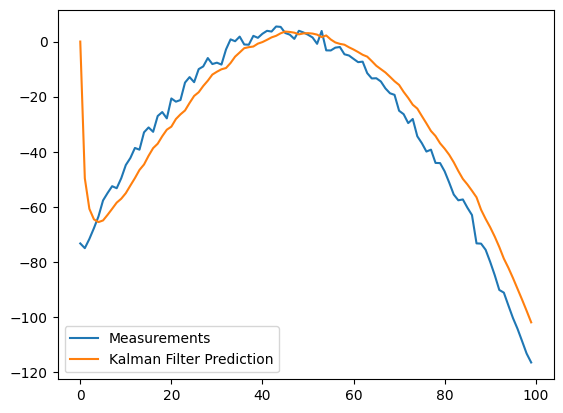

In [4]:
def example():
  A = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
  H = np.array([1, 0, 0]).reshape(1, 3)
  Q = np.array([[0.05, 0.05, 0.0], [0.05, 0.05, 0.0], [0.0, 0.0, 0.0]])
  R = np.array([0.5]).reshape(1, 1)

  x = np.linspace(-10, 10, 100)
  measurements = - (x**2 + 2*x - 2)  + np.random.normal(0, 2, 100)

  kf = KalmanFilter(A = A, H = H, Q = Q, R = R)
  predictions = []

  for z in measurements:
    predictions.append(np.dot(H,  kf.predict())[0])
    kf.update(z)

  plt.plot(range(len(measurements)), measurements, label = 'Measurements')
  plt.plot(range(len(predictions)), np.array(predictions), label = 'Kalman Filter Prediction')
  plt.legend()
  plt.show()

if __name__ == '__main__':
    example()